# Einführung in CNNs

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import matplotlib.pylab as plt
import numpy as np

In [4]:
from distutils.version import StrictVersion

In [5]:
import sklearn
print(sklearn.__version__)

assert StrictVersion(sklearn.__version__ ) >= StrictVersion('0.18.1')

0.18.1


In [6]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

assert StrictVersion(tf.__version__) >= StrictVersion('1.1.0')

1.2.1


In [7]:
import keras
print(keras.__version__)

assert StrictVersion(keras.__version__) >= StrictVersion('2.0.0')

Using TensorFlow backend.


2.0.6


In [8]:
import pandas as pd
print(pd.__version__)

assert StrictVersion(pd.__version__) >= StrictVersion('0.19.0')

0.20.1


## Laden und Vorbereiten der Bild-Daten

In [9]:
!curl -O https://raw.githubusercontent.com/DJCordhose/speed-limit-signs/master/data/speed-limit-signs.zip
from zipfile import ZipFile
zip = ZipFile(r'speed-limit-signs.zip')
zip.extractall('.')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1810k  100 1810k    0     0  5236k      0 --:--:-- --:--:-- --:--:-- 5419k


In [10]:
!ls -l speed-limit-signs

total 28
drwxrwxr-x 2 ubuntu ubuntu 4096 Aug 29 07:45 0
drwxrwxr-x 2 ubuntu ubuntu 4096 Aug 29 07:45 1
drwxrwxr-x 2 ubuntu ubuntu 4096 Aug 29 07:45 2
drwxrwxr-x 2 ubuntu ubuntu 4096 Aug 29 07:45 3
drwxrwxr-x 2 ubuntu ubuntu 4096 Aug 29 07:45 4
drwxrwxr-x 2 ubuntu ubuntu 4096 Aug 29 07:45 5
-rw-rw-r-- 1 ubuntu ubuntu  380 Aug 29 07:45 README.md


In [11]:
!cat speed-limit-signs/README.md

Data extracted from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

From http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip just the samples for the speed limit signs 

## Format

https://en.wikipedia.org/wiki/Netpbm_format

Can be previewed on a Mac and be processed by http://scikit-image.org/

## Labels
- 0: 30
- 1: 50
- 2: 70
- 3: 80
- 4: 100
- 5: 120

# Big Kudos to [Waleed Abdulla](https://medium.com/@waleedka) for providing the initial idea and many of the functions used to prepare and display the images: https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6#.i728o84ib  

In [12]:
import os
import skimage.data
import skimage.transform
from keras.utils.np_utils import to_categorical
import numpy as np

def load_data(data_dir, type=".ppm"):
    num_categories = 6

    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(type)]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    images64 = [skimage.transform.resize(image, (64, 64)) for image in images]
    return images64, labels

In [13]:
# Load datasets.
ROOT_PATH = "./"
original_dir = os.path.join(ROOT_PATH, "speed-limit-signs")
images, labels = load_data(original_dir, type=".ppm")

In [14]:
import matplotlib
import matplotlib.pyplot as plt

def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)

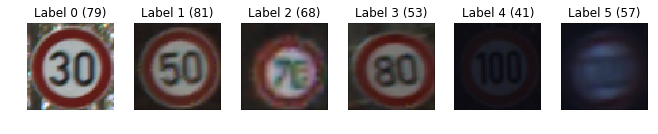

In [15]:
display_images_and_labels(images, labels)

## Modell-Architektur
http://cs231n.github.io/neural-networks-1/#power

### Layout of a typical CNN

![Layout of a typical CNN](https://github.com/DJCordhose/speed-limit-signs/raw/master/img/convnet-layoyt.jpeg)
http://cs231n.github.io/convolutional-networks/

### Classic VGG like Architecture
* we use a VGG like architecture
* based on https://arxiv.org/abs/1409.1556
* basic idea: sequential, deep, small convolutional filters, use dropouts to reduce overfitting
* 16/19 layers are typical
* we choose less layers, because we have limited resources

### Convolutional Blocks: Cascading many Convolutional Layers having down sampling in between

![Applying filters](http://cs231n.github.io/assets/cnn/cnn.jpeg)

http://cs231n.github.io/convolutional-networks/#conv

### Example of a Convolution
#### Original Image
![Dog](https://github.com/DJCordhose/speed-limit-signs/raw/master/img/conv/dog.png)
#### Many convolutional filters applied over all channels
![Dog after Convolutional Filters applied](https://github.com/DJCordhose/speed-limit-signs/raw/master/img/conv/dog-conv1.png)
http://cs.stanford.edu/people/karpathy/convnetjs/demo/cifar10.html

### Downlsampling Layer: Reduces data sizes and risk of overfitting
![Pooling](http://cs231n.github.io/assets/cnn/pool.jpeg)
![Max Pooling](http://cs231n.github.io/assets/cnn/maxpool.jpeg)
http://cs231n.github.io/convolutional-networks/#pool

In [16]:
y = np.array(labels)
X = np.array(images)
from keras.utils.np_utils import to_categorical

num_categories = 6

y = to_categorical(y, num_categories)

In [17]:
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

# input tensor for a 3-channel 64x64 image
inputs = Input(shape=(64, 64, 3))

# one block of convolutional layers
x = Convolution2D(64, 3, activation='relu', padding='same')(inputs)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# one more block
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# one more block
x = Convolution2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

# softmax activation, 6 categories
predictions = Dense(6, activation='softmax')(x)

In [18]:
model = Model(input=inputs, output=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       147584    
__________

In [19]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Optimizers: Adam and RMSprop seem nice
![Behavior of Optimizers at Saddle Points](http://cs231n.github.io/assets/nn3/opt1.gif)
![Visualization of Optimizers](http://cs231n.github.io/assets/nn3/opt2.gif)
http://cs231n.github.io/neural-networks-3/#ada

## Zuerst testen wir unser Modell, ob wir es überhaupt trainiert bekommen, indem wir auf einer kleinen Menge von Daten overfitten
http://cs231n.github.io/neural-networks-3/#sanitycheck

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42, stratify=y)

In [21]:
X_train.shape, y_train.shape

((37, 64, 64, 3), (37, 6))

In [22]:
%time model.fit(X_train, y_train, epochs=100, validation_split=0.3)

Train on 25 samples, validate on 12 samples
Epoch 1/100
25/25 [==============================] - 5s - loss: 1.7939 - acc: 0.2000 - val_loss: 1.7835 - val_acc: 0.0833
Epoch 2/100
25/25 [==============================] - 0s - loss: 1.6448 - acc: 0.2800 - val_loss: 3.3576 - val_acc: 0.0833
Epoch 3/100
25/25 [==============================] - 0s - loss: 2.3333 - acc: 0.2800 - val_loss: 1.8305 - val_acc: 0.0833
Epoch 4/100
25/25 [==============================] - 0s - loss: 1.5742 - acc: 0.2800 - val_loss: 1.7597 - val_acc: 0.1667
Epoch 5/100
25/25 [==============================] - 0s - loss: 1.6860 - acc: 0.1600 - val_loss: 1.7621 - val_acc: 0.2500
Epoch 6/100
25/25 [==============================] - 0s - loss: 1.7263 - acc: 0.3200 - val_loss: 1.7662 - val_acc: 0.0833
Epoch 7/100
25/25 [==============================] - 0s - loss: 1.7369 - acc: 0.4000 - val_loss: 1.7669 - val_acc: 0.0833
Epoch 8/100
25/25 [==============================] - 0s - loss: 1.7287 - acc: 0.4000 - val_loss: 1.767

25/25 [==============================] - 0s - loss: 0.0101 - acc: 1.0000 - val_loss: 4.8548 - val_acc: 0.4167
Epoch 68/100
25/25 [==============================] - 0s - loss: 0.0280 - acc: 1.0000 - val_loss: 4.9492 - val_acc: 0.4167
Epoch 69/100
25/25 [==============================] - 0s - loss: 0.0077 - acc: 1.0000 - val_loss: 5.0696 - val_acc: 0.4167
Epoch 70/100
25/25 [==============================] - 0s - loss: 0.0067 - acc: 1.0000 - val_loss: 5.1991 - val_acc: 0.5000
Epoch 71/100
25/25 [==============================] - 0s - loss: 0.0069 - acc: 1.0000 - val_loss: 5.3247 - val_acc: 0.5000
Epoch 72/100
25/25 [==============================] - 0s - loss: 0.0070 - acc: 1.0000 - val_loss: 5.4275 - val_acc: 0.5000
Epoch 73/100
25/25 [==============================] - 0s - loss: 0.0065 - acc: 1.0000 - val_loss: 5.4969 - val_acc: 0.5000
Epoch 74/100
25/25 [==============================] - 0s - loss: 0.0058 - acc: 1.0000 - val_loss: 5.5360 - val_acc: 0.5000
Epoch 75/100
25/25 [=========

## Verlauf der Metriken beim Overfitting
### Accuracy
![Accuracy Overfitting](https://djcordhose.github.io/ai/img/tensorboard/cnn-acc-overfitting.png "Accuracy Overfitting")
### Validation Accuracy
![Validation Accuracy Overfitting](https://djcordhose.github.io/ai/img/tensorboard/cnn-val-acc-overfitting.png "Validation Accuracy Overfitting")

## Das sieht gut aus, nun versuchen wir es mit dem kompletten Datensatz ohne Overfitting und mit Dropout

In [40]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

# this is important, try and vary between .4 and .75
drop_out = 0.7

# input tensor for a 3-channel 64x64 image
inputs = Input(shape=(64, 64, 3))

# one block of convolutional layers
x = Convolution2D(64, 3, activation='relu', padding='same')(inputs)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

# one more block
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

# one more block
x = Convolution2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(drop_out)(x)

# softmax activation, 6 categories
predictions = Dense(6, activation='softmax')(x)

In [41]:
model = Model(input=inputs, output=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 128)       73856     
__________

In [42]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Training
* Auf einem GPU basierten System geht das in ein paar Minuten
* Azure Rechner sind relativ schnell, haben aber keine GPU
* Hier dauert jede Epoche ca. 10 Sekunden, bei 500 Epochen = 5000 Sekunden = 1,5 Stunden
* Das können wir nicht warten
* Stattdessen trainieren wir mit diesem Notebook gemeinsam ein Modell auf einer K80 GPU
* dieses Modell wird dann geteilt und jeder macht dann die Auswertung wieder in seinem Notebook
* Während das Modell trainiert (dauert auf K80 GPU nur ein paar Minuten) sehen wir uns das TensorBoard an und verfolgen das Training
  * Loss, Accuracy, Validation Loss, Validation Accuracy

In [44]:
# https://keras.io/callbacks/#tensorboard
tb_callback = keras.callbacks.TensorBoard(log_dir='./tf_log')
# To start tensorboard
# tensorboard --logdir=/mnt/c/Users/olive/Development/ml/tf_log
# open http://localhost:6006

In [49]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, verbose=1)

In [54]:
checkpoint_callback = keras.callbacks.ModelCheckpoint('./model-checkpoints/weights.epoch-{epoch:02d}-val_loss-{val_loss:.2f}.hdf5');

In [51]:
!rm -r tf_log

In [52]:
# Depends on harware GPU architecture, set as high as possible (this works well on K80)
BATCH_SIZE = 500
# %time model.fit(X_train, y_train, epochs=500, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback, early_stopping_callback])
%time model.fit(X_train, y_train, epochs=500, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback])
# %time model.fit(X_train, y_train, epochs=500, batch_size=BATCH_SIZE, validation_split=0.2)

Train on 242 samples, validate on 61 samples
Epoch 1/500
242/242 [==============================] - 1s - loss: 1.1399 - acc: 0.5537 - val_loss: 1.8481 - val_acc: 0.3934
Epoch 2/500
242/242 [==============================] - 0s - loss: 1.1650 - acc: 0.5083 - val_loss: 1.9291 - val_acc: 0.4590
Epoch 3/500
242/242 [==============================] - 0s - loss: 1.1924 - acc: 0.5207 - val_loss: 1.8771 - val_acc: 0.4918
Epoch 4/500
242/242 [==============================] - 0s - loss: 1.1175 - acc: 0.5455 - val_loss: 1.9865 - val_acc: 0.4426
Epoch 5/500
242/242 [==============================] - 0s - loss: 1.1362 - acc: 0.4959 - val_loss: 2.1604 - val_acc: 0.4426
Epoch 6/500
242/242 [==============================] - 0s - loss: 1.0366 - acc: 0.5537 - val_loss: 2.2037 - val_acc: 0.4590
Epoch 7/500
242/242 [==============================] - 0s - loss: 1.2770 - acc: 0.5083 - val_loss: 1.7027 - val_acc: 0.4754
Epoch 8/500
242/242 [==============================] - 0s - loss: 1.1607 - acc: 0.5041 

242/242 [==============================] - 0s - loss: 0.6630 - acc: 0.7603 - val_loss: 1.8482 - val_acc: 0.5246
Epoch 67/500
242/242 [==============================] - 0s - loss: 0.6585 - acc: 0.7603 - val_loss: 1.9853 - val_acc: 0.5902
Epoch 68/500
242/242 [==============================] - 0s - loss: 0.6643 - acc: 0.7397 - val_loss: 1.9533 - val_acc: 0.5902
Epoch 69/500
242/242 [==============================] - 0s - loss: 0.6805 - acc: 0.7355 - val_loss: 1.8779 - val_acc: 0.5902
Epoch 70/500
242/242 [==============================] - 0s - loss: 0.6655 - acc: 0.7438 - val_loss: 1.8835 - val_acc: 0.5738
Epoch 71/500
242/242 [==============================] - 0s - loss: 0.6672 - acc: 0.7603 - val_loss: 1.9669 - val_acc: 0.5902
Epoch 72/500
242/242 [==============================] - 0s - loss: 0.6879 - acc: 0.7107 - val_loss: 2.0078 - val_acc: 0.5410
Epoch 73/500
242/242 [==============================] - 0s - loss: 0.7238 - acc: 0.7107 - val_loss: 1.7524 - val_acc: 0.5410
Epoch 74/500


## Idealer Verlauf der Metriken beim vollen Training

100% bei Training und über 95% bei Validation sind möglich, sind bei der Datenmenge aber mit Vorsicht zu genießen

### Accuracy
![Accuracy](https://djcordhose.github.io/ai/img/tensorboard/cnn-acc.png "Accuracy")
### Validation Accuracy
![Validation Accuracy](https://djcordhose.github.io/ai/img/tensorboard/cnn-val-acc.png "Validation Accuracy")

# Sichern des Modells (falls in diesem Notebook trainiert wurde)
* unser Modell ist 55 MB groß, das ist ein wirklich großes Modell

In [34]:
model.save('conv-vgg.hdf5')

In [35]:
!ls -lh

total 57M
-rw-rw-r-- 1 ubuntu ubuntu 186K Aug 29 08:09 cnn-intro.ipynb
-rw-rw-r-- 1 ubuntu ubuntu  55M Aug 29 08:10 conv-vgg.hdf5
drwxrwxr-x 3 ubuntu ubuntu 4.0K Aug 29 07:45 __MACOSX
-rw------- 1 ubuntu ubuntu 4.2K Aug 29 08:09 nohup.out
drwxrwxr-x 8 ubuntu ubuntu 4.0K Aug 29 07:45 speed-limit-signs
-rw-rw-r-- 1 ubuntu ubuntu 1.8M Aug 29 07:45 speed-limit-signs.zip
drwxr-xr-x 2 ubuntu ubuntu 4.0K Aug 29 08:01 tf_log


In [36]:
# https://transfer.sh/
# Speichert eure Daten für 14 Tage
!curl --upload-file conv-vgg.hdf5 https://transfer.sh/conv-vgg.hdf5

# Vortrainiertes Modell
# loss: 0.0310 - acc: 0.9917 - val_loss: 0.4075 - val_acc: 0.9508
# https://transfer.sh/B1W8e/conv-vgg.hdf5

https://transfer.sh/B1W8e/conv-vgg.hdf5

# ODER Laden des trainierten Modells

In [59]:
!ls -lh

total 2.0M
-rw-rw-r-- 1 ubuntu ubuntu 131K Aug 29 08:29 cnn-intro.ipynb
drwxrwxr-x 3 ubuntu ubuntu 4.0K Aug 29 07:45 __MACOSX
-rw------- 1 ubuntu ubuntu 4.8K Aug 29 08:29 nohup.out
drwxrwxr-x 8 ubuntu ubuntu 4.0K Aug 29 07:45 speed-limit-signs
-rw-rw-r-- 1 ubuntu ubuntu 1.8M Aug 29 07:45 speed-limit-signs.zip
drwxr-xr-x 2 ubuntu ubuntu 4.0K Aug 29 08:17 tf_log


In [58]:
!rm conv-vgg.hdf5

In [60]:
# anpassen an aktuelles Modell
!curl -O https://transfer.sh/B1W8e/conv-vgg.hdf5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 54.8M  100 54.8M    0     0  7649k      0  0:00:07  0:00:07 --:--:-- 10.3M


In [61]:
!ls -lh

total 57M
-rw-rw-r-- 1 ubuntu ubuntu 131K Aug 29 08:31 cnn-intro.ipynb
-rw-rw-r-- 1 ubuntu ubuntu  55M Aug 29 08:30 conv-vgg.hdf5
drwxrwxr-x 3 ubuntu ubuntu 4.0K Aug 29 07:45 __MACOSX
-rw------- 1 ubuntu ubuntu 4.9K Aug 29 08:31 nohup.out
drwxrwxr-x 8 ubuntu ubuntu 4.0K Aug 29 07:45 speed-limit-signs
-rw-rw-r-- 1 ubuntu ubuntu 1.8M Aug 29 07:45 speed-limit-signs.zip
drwxr-xr-x 2 ubuntu ubuntu 4.0K Aug 29 08:17 tf_log


In [62]:
from keras.models import load_model
model = load_model('conv-vgg.hdf5')

# Bewertung

In [63]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

303/303 [==============================] - 2s


(0.082067638635635376, 0.99009901285171509)

In [64]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

76/76 [==============================] - 0s


(0.25680279731750488, 0.94736838340759277)

# Ausprobieren auf ein paar Test-Daten

In [71]:
import random

# Pick 10 random images for test data set
random.seed(4) # to make this deterministic
sample_indexes = random.sample(range(len(X_test)), 10)
sample_images = [X_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

ground_truth = np.argmax(sample_labels, axis=1)

X_sample = np.array(sample_images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
predicted_categories

array([1, 0, 4, 0, 0, 5, 4, 0, 0, 0])

In [72]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(5, 2,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(80, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
                 fontsize=12, color=color)
        plt.imshow(images[i])

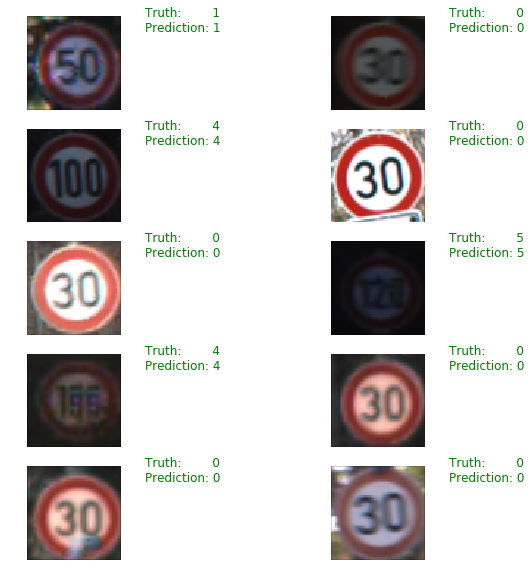

In [73]:
display_prediction(sample_images, ground_truth, predicted_categories)